In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.time import parse_time
from sunpy.coordinates import frames

from astropy import units as u
from sunpy.time import parse_time
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from sunpy.map import Map
import sunpy.map
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord, transform_with_sun_center
from astropy.visualization import ImageNormalize, LogStretch
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from sunpy.coordinates import get_horizons_coord
from sunpy.map import get_observer_meta
import matplotlib

ModuleNotFoundError: No module named 'bs4'

In [2]:
result = Fido.search(a.Time("2021-11-01 01:24", "2021-11-01 01:32"), 
                     a.Instrument.xrs  | (a.Instrument.aia & a.Wavelength(171*u.angstrom)& a.Sample(2*u.min)))
result

/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/table/table.py:3474: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


<sunpy.net.fido_factory.UnifiedResponse object at 0x7f06024da580>
Results from 2 Providers:

2 Results from the XRSClient:
Source: https://umbra.nascom.nasa.gov/goes/fits

       Start Time               End Time        Instrument SatelliteNumber  Physobs   Source Provider
----------------------- ----------------------- ---------- --------------- ---------- ------ --------
2021-11-01 00:00:00.000 2021-11-01 23:59:59.999        XRS              16 irradiance   GOES     NOAA
2021-11-01 00:00:00.000 2021-11-01 23:59:59.999        XRS              17 irradiance   GOES     NOAA

4 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 271.155 Mbyte

       Start Time               End Time        Source ...   Size                              Info                          
                                                       ...  Mibyte                                                           
----------------------- ----------------------- ------ ... -------- ---------------------------------------------------------
2021-11-01 01:24:09.000 2021-11-01 01:24:10.000    SDO ... 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]
2021-11-01 01:26:09.000 2021-11-01 01:26:10.000    SDO ... 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]
2021-11-01 01:28:09.000 2021-11-01 01:28:10.000    SDO ... 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]
2021-11-01 01:30:09.000 2021-11-01 01:30:10.000    SDO ... 64.64844 AIA level 1, 4096x4096 [2.000 exposure] [100.00 percentd]

In [3]:
Fido.fetch(result, path="../event20211101_012200/AIA/")

Files Downloaded:   0%|          | 0/6 [00:00<?, ?file/s]

sci_xrsf-l2-flx1s_g17_d20211101_v2-1-0.nc:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

sci_xrsf-l2-flx1s_g16_d20211101_v2-1-0.nc:   0%|          | 0.00/5.05M [00:00<?, ?B/s]

['../event20211101_012200/AIA/sci_xrsf-l2-flx1s_g16_d20211101_v2-1-0.nc', '../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_30_09_35z_image_lev1.fits', '../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_26_09_35z_image_lev1.fits', '../event20211101_012200/AIA/sci_xrsf-l2-flx1s_g17_d20211101_v2-1-0.nc', '../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_24_09_35z_image_lev1.fits', '../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_28_09_35z_image_lev1.fits']

In [4]:
fig=plt.figure(figsize=(8,8))
for i in range(len(aia_files)):
    #wcs = WCS(hdulist[0].header)   # warning about CROTA, but WCS uses PCi_j anyway
    eui_map = sunpy.map.Map(aia_files[i])
    #eui_map.plot_settings["norm"] = ImageNormalize(vmin=150, vmax=10000, stretch=LogStretch())

    ax = fig.add_subplot(2,int(len(aia_files)/2),i+1,projection=eui_map)

    eui_map.plot(axes=ax,cmap="hot")
    #eui_map.draw_grid(color="g")

    

NameError: name 'aia_files' is not defined

<Figure size 576x576 with 0 Axes>

In [14]:
eui_sub,sublimits = constrain_eui2stix(eui_map,stxmap,margin=0)#,bias=[-100,100])
fig=plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1,projection=eui_sub)
eui_sub.plot(axes=ax)
eui_sub.draw_grid(axes=ax)

NameError: name 'stxmap' is not defined

In [ ]:
eui_map.coordinate_frame

In [84]:
def create_stix_map(path,position=None):
    u.add_enabled_units([u.def_unit("arcsecs", 1 * u.arcsec)])

    hdulist = fits.open(path)
    
    filename  = path.split("/")[-1]
    hdulist[0].header["DATE-OBS"] = Time.strptime(filename.split("_")[2], "%d-%b-%YT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
    hdulist[0].header["ERANGE"]=str(int(filename.split("_")[3]))+"-"+str(int(filename.split("_")[4].split(".")[0]))
    hdulist[0].header["METHOD"]=filename.split("_")[1]
    stix_map = Map(hdulist[0].data, hdulist[0].header)
    if position:
        stix_map.meta.update(get_observer_meta(position, rsun=position.rsun))

    
    return stix_map,hdulist

#solo_pos = get_horizons_coord("SOLO", eui_map.date)


euisitxfiles={
    "date1":{"AIA":0,"STX_E1":0,"STX_E2":1,},
    "date2":{"AIA":1,"STX_E1":2,"STX_E2":3,},
    "date3":{"AIA":2,"STX_E1":4,"STX_E2":5,},
    "date4":{"AIA":3,"STX_E1":6,"STX_E2":7,},
}

#aia_files = glob.glob("../event20211101_012200/AIA/*.fits"); aia_files.sort()
#stxmap_files =  glob.glob("../event20211101_012200/stxmaps_20211101/*.fits");stxmap_files.sort()

def pair_aia_stix_files(aia_path,stix_path,e_levels=2):
    
    aia_files = glob.glob(aia_path+"*.fits"); aia_files.sort()
    stxmap_files =  glob.glob(stix_path+"*.fits");stxmap_files.sort()
    
    aia_stix = {}
    
    n_images = len(aia_files)    
    for i in range(n_images):
        aia_ = aia_files[i]
        aia_stix[i]={"AIA":aia_}
        init_number = i*e_levels
        for j in range(e_levels):
            aia_stix[i]["E_"+str(j+1)] = stxmap_files[init_number+j]
    return aia_stix
            
        
def constrain_eui2stix(eui_map,stx_map,margin=100,bias=[0,0]):
    
    tx_bl = stx_map.bottom_left_coord.helioprojective.Tx.arcsec+bias[0]-margin
    ty_bl = stx_map.bottom_left_coord.helioprojective.Ty.arcsec+bias[1]-margin
    
    tx_tr = stx_map.top_right_coord.helioprojective.Tx.arcsec+bias[0]+margin
    ty_tr = stx_map.top_right_coord.helioprojective.Ty.arcsec+bias[1]+margin
    
    print(tx_bl,ty_bl)
    print(tx_tr,ty_tr)
    
    
    
    bottom_left = SkyCoord(tx_bl*u.arcsec,ty_bl*u.arcsec, frame=stx_map.coordinate_frame)
    top_right = SkyCoord(tx_tr*u.arcsec, ty_tr*u.arcsec, frame=stx_map.coordinate_frame) 
    
    bottom_left.transform_to(eui_map.coordinate_frame)
    top_right.transform_to(eui_map.coordinate_frame)

    submap = eui_map.submap(bottom_left=bottom_left, top_right=top_right)
    
    return submap,[bottom_left,top_right]




INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
[0]  aia_lev1_171a_2021_11_01t01_24_09_35z_image_lev1.fits
  [0]  stxmap_CLEAN_01-Nov-2021T01:24:45_12_16.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616


/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/patches.py:179: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


  [1]  stxmap_CLEAN_01-Nov-2021T01:24:45_4_8.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
[1]  aia_lev1_171a_2021_11_01t01_26_09_35z_image_lev1.fits
  [0]  stxmap_CLEAN_01-Nov-2021T01:26:45_12_16.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616


/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/patches.py:179: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


  [1]  stxmap_CLEAN_01-Nov-2021T01:26:45_4_8.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
[2]  aia_lev1_171a_2021_11_01t01_28_09_35z_image_lev1.fits
  [0]  stxmap_CLEAN_01-Nov-2021T01:27:55_12_16.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616


/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/patches.py:179: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


  [1]  stxmap_CLEAN_01-Nov-2021T01:27:55_4_8.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
[3]  aia_lev1_171a_2021_11_01t01_30_09_35z_image_lev1.fits
  [0]  stxmap_CLEAN_01-Nov-2021T01:30:50_12_16.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616


/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/patches.py:179: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


  [1]  stxmap_CLEAN_01-Nov-2021T01:30:50_4_8.fits
453.30144996996125 -686.0548071754591
908.0164649337602 -395.2533496341616


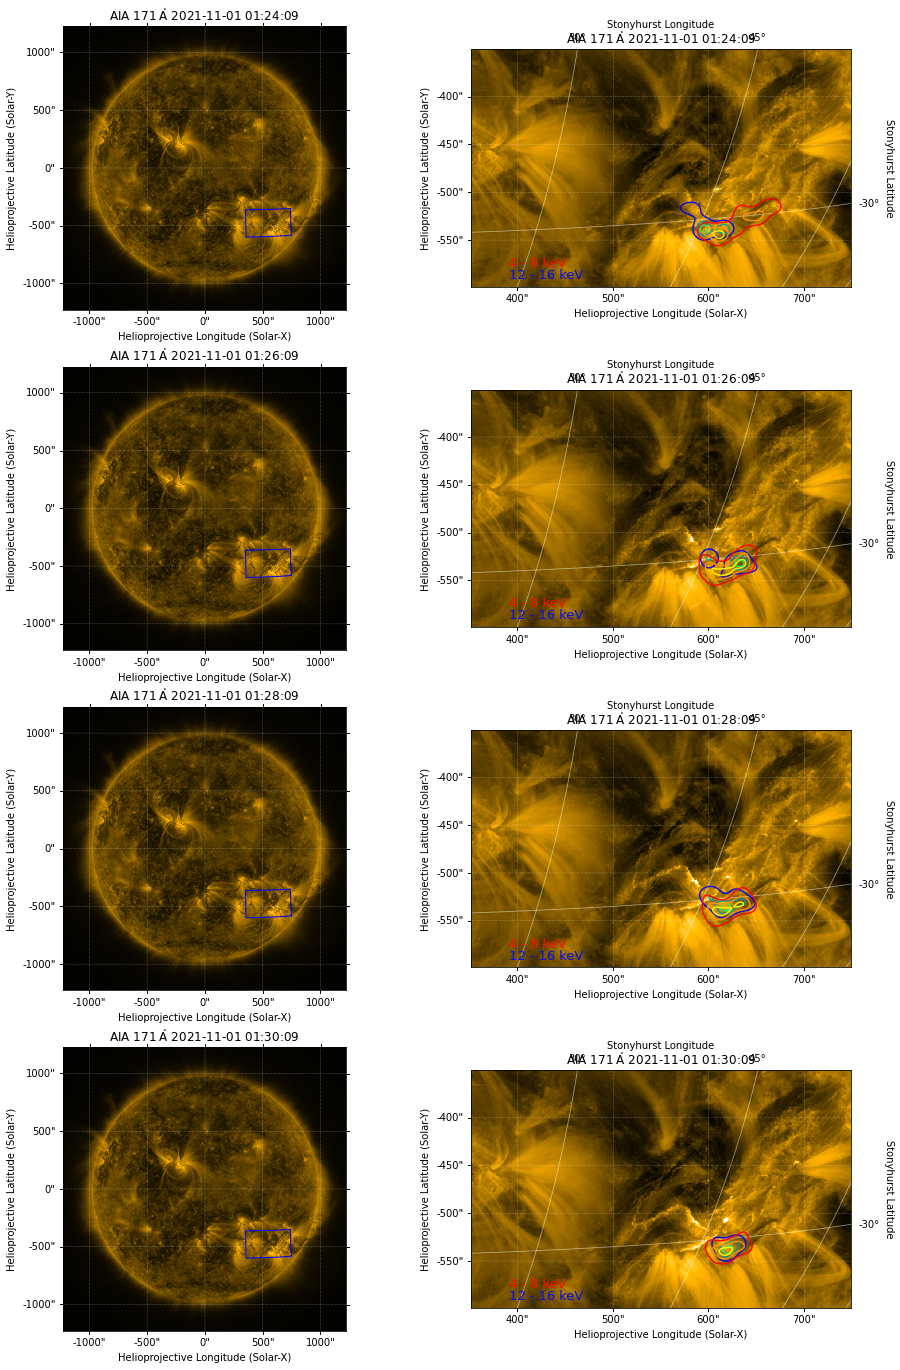

In [104]:
#eui_sub,sublimits = constrain_eui2stix(eui_map,stxmap,margin=0)#,bias=[-100,100])
imgfiles_aia_stix = pair_aia_stix_files("../event20211101_012200/AIA/","../event20211101_012200/stxmaps_20211101/",e_levels=2)

levels = [40,70,90]
cmaps =["winter","autumn"]
#cmaps = ["Reds","Blues"]
n_pairs = len(imgfiles_aia_stix.keys())

fig=plt.figure(figsize=(15,6*n_pairs))
for i in range(n_pairs):
    entry=imgfiles_aia_stix[i]
    
    eui_map = sunpy.map.Map(entry["AIA"])
    solo_pos = get_horizons_coord("SOLO", eui_map.date)
    
    print("[{}]  ".format(i)+entry["AIA"].split("/")[-1])
    starting = 2*i+1
    # left plot
    ax = fig.add_subplot(n_pairs,2,starting,projection=eui_map)
    
    #map
    eui_map.plot(axes=ax)
    
    
    
    #right plot
    n_energies = [x for x in entry.keys() if x.startswith("E_")]
    
    
    
    
    for e_idx in range(len(n_energies)):
        e = n_energies[e_idx]
        print("  [{}]  ".format(e_idx)+entry[e].split("/")[-1])
        stx_map,stxhdu = create_stix_map(entry[e],position=solo_pos)
        eui_sub,limits = constrain_eui2stix(eui_map=eui_map,stx_map=stx_map,margin=80,bias=[-70,70])
        
        
        
        #with frames.Helioprojective.assume_spherical_screen(stx_map.observer_coordinate):
        if(e_idx==0):
            eui_map.draw_quadrangle(limits[0], top_right=limits[1], 
                    axes=ax,color="b")
            ax2 = fig.add_subplot(n_pairs,2,starting+1,projection=eui_sub)
            plt.title("3")
            eui_sub.plot(axes=ax2)
            
            eui_sub.draw_grid(axes=ax2,color="w")
            bounds = ax2.axis()
        
        
        erange = [int(x) for x in stx_map.meta['erange'].split('-')]
        txt = '{} - {} keV'.format(erange[0],erange[1])
        cmap = matplotlib.cm.get_cmap(cmaps[e_idx])
        rgba = cmap(0.05)
        
        stx_map.draw_contours(levels*u.percent,cmap=cmaps[e_idx],axes=ax2,alpha=0.9)
        #stx_map.draw_grid(axes=ax2)
        ax2.axis(bounds)
        ax2.text(0.1, 0.05+0.05*e_idx,txt, horizontalalignment='left',
     verticalalignment='center', transform=ax2.transAxes,fontsize=13,color=rgba)
plt.show()

    
    

    



#eui_map.draw_quadrangle(sublimits[0], top_right=sublimits[1], 
#                        axes=ax,color="b")
    

#submap.draw_grid(color="g")

    
    
    #stxmap_high.draw_contours([70,95]*u.percent,c="k",cmap="winter",axes=ax2)
#comp_map2.plot(axes=ax3,autoalign=True)


In [97]:
plt.close()

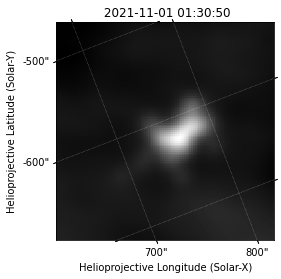

In [25]:
stx_map.plot()

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

In [71]:
stx_map.top_right_coord.helioprojective.Ty

<Latitude -545.25334963 arcsec>

In [43]:
stx_map.coordinate_frame

<Helioprojective Frame (obstime=2021-11-01T01:30:50.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-11-01T01:30:50.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-1.72151144, 2.11144668, 1.23668387e+11)>)>

In [44]:
eui_sub.coordinate_frame

<Helioprojective Frame (obstime=2021-11-01T01:30:09.350, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2021-11-01T01:30:09.350, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01604128, 4.37895508, 1.48497691e+11)>)>

400 -700
700 -300


<CoordinatesMap with 2 world coordinates:

  index aliases    type   unit wrap format_unit visible
  ----- ------- --------- ---- ---- ----------- -------
      0     lon longitude  deg  180         deg     yes
      1     lat  latitude  deg None         deg     yes

>

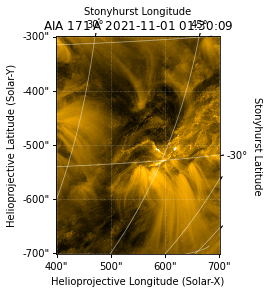

In [22]:
eui_map
tx_bl =400
ty_bl = -700
tx_tr = 700
ty_tr = -300

print(tx_bl,ty_bl)
print(tx_tr,ty_tr)



bottom_left = SkyCoord(tx_bl*u.arcsec,ty_bl*u.arcsec, frame=eui_map.coordinate_frame)
top_right = SkyCoord(tx_tr*u.arcsec, ty_tr*u.arcsec, frame=eui_map.coordinate_frame) 
submap = eui_map.submap(bottom_left=bottom_left, top_right=top_right)


submap.plot()
submap.draw_grid()

/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


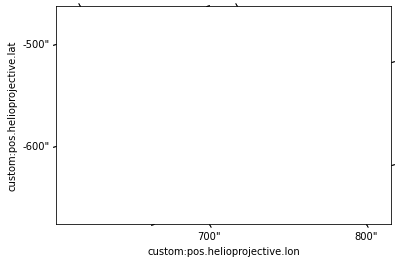

In [37]:

stx_map.draw_contours(levels=[40,70,90],cmap="jet")

In [14]:
EUI_name = "../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_24_09_35z_image_lev1.fits"
#EUI_name = "solo_L2_eui-hrilya1216-image_20201119T065800218_V04.fits"
hdulist = fits.open(EUI_name)
hdulist.info()

wcs = WCS(hdulist[0].header)   # warning about CROTA, but WCS uses PCi_j anyway
eui_map = sunpy.map.Map(EUI_name)

Filename: ../event20211101_012200/AIA/aia_lev1_171a_2021_11_01t01_24_09_35z_image_lev1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    188   (4096, 4096)   int16   


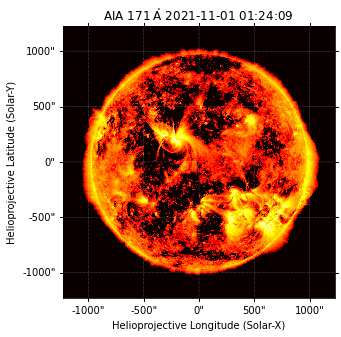

In [15]:
eui_map.plot_settings["norm"] = ImageNormalize(vmin=150, vmax=5000, stretch=LogStretch())

fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(1,1,1,projection=eui_map)

eui_map.plot(axes=ax,cmap="hot")
#eui_map.draw_grid(color="g")

In [241]:
file_10_14 = "stxmaps_20201119/20201119/stxmap_MEM_19-Nov-2020T05:52:00_10_14.fits"
file_4_8 = "stxmaps_20201119/20201119/stxmap_MEM_19-Nov-2020T05:52:00_4_8.fits"
u.add_enabled_units([u.def_unit("arcsecs", 1 * u.arcsec)])

hdulist_low = fits.open(file_4_8)
hdulist_high = fits.open(file_10_14)

hdulist_low[0].header["DATE-OBS"] = Time.strptime(file_4_8.split("_")[3], "%d-%b-%YT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
stix_map_low = Map(hdulist_low[0].data, hdulist_low[0].header)

hdulist_high[0].header["DATE-OBS"] = Time.strptime(file_10_14.split("_")[3], "%d-%b-%YT%H:%M:%S").strftime("%Y-%m-%d %H:%M:%S")
stix_map_high = Map(hdulist_high[0].data, hdulist_high[0].header)

solo_pos = get_horizons_coord("SOLO", eui_map.date)

stix_map_low.meta.update(get_observer_meta(solo_pos, rsun=solo_pos.rsun))
stix_map_high.meta.update(get_observer_meta(solo_pos, rsun=solo_pos.rsun))


INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [242]:
bottom_left = SkyCoord(850*u.arcsec,-460*u.arcsec, frame=eui_map.coordinate_frame)
top_right = SkyCoord(1080*u.arcsec, -230*u.arcsec, frame=eui_map.coordinate_frame) 
submap = eui_map.submap(bottom_left=bottom_left, top_right=top_right)
#comp_map2 = Map(submap, m_stix, composite=True)

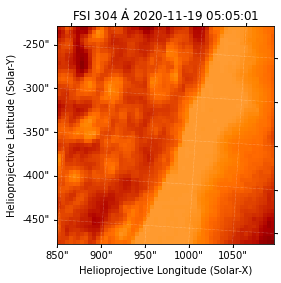

In [243]:
submap.plot()

/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/patches.py:179: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)
/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: The following kwargs were not used by contour: 'c'
  cset = super().contour(*args, **kwargs)
/home/localuser/miniconda3/envs/sunpy-tutorial/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: The following kwargs were not used by contour: 'c'
  cset = super().contour(*args, **kwargs)


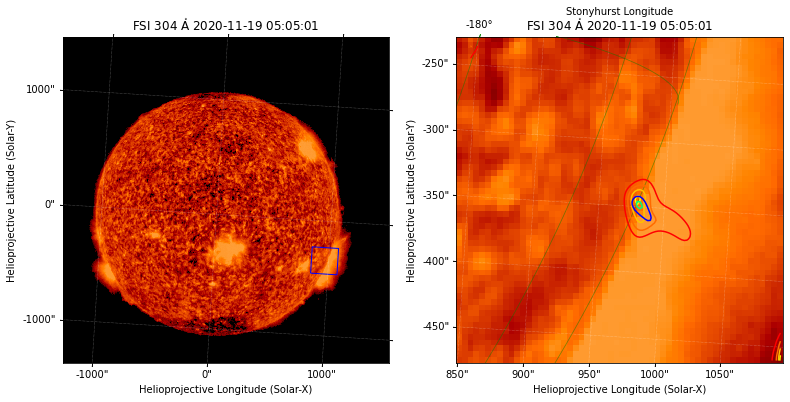

In [244]:
levels = [30,50,70,90]
fig=plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,3,1,projection=eui_map)
#stix_map.draw_contours([50,70,90]*u.percent)
eui_map.plot(axes=ax)
eui_map.draw_quadrangle(bottom_left, top_right=top_right, 
                        axes=ax,color="b")
    
ax2 = fig.add_subplot(1,3,2,projection=submap)

#submap.draw_grid(color="g")
from sunpy.coordinates import frames
with frames.Helioprojective.assume_spherical_screen(submap.observer_coordinate):
    submap.plot(axes=ax2)
    submap.draw_grid(axes=ax2,color="g")
    
    stix_map_low.draw_contours([35,60,80,95]*u.percent,c="k",cmap="autumn",axes=ax2)
    stix_map_high.draw_contours([70,95]*u.percent,c="k",cmap="winter",axes=ax2)
#comp_map2.plot(axes=ax3,autoalign=True)
plt.show()

In [3]:
import numpy as np


def k_from_v(v):

    m = 9.31e-31 #kg
    c = 3e8 #m/S
    #v = 0.25

    beta = v
    gamma = 1/np.sqrt(1-beta**2)
    

    conv = 6.24e18 # ev perjoule
    k = 0.5*m*(v*c)**2 #kg m2/s2 Joule
    k_rel = (gamma-1)*m*c**2

    k_conv = conv*k #ev
    k_kev= k_conv/1000. #kev

    k_conv_rel = conv*k_rel #ev
    k_kev_rel= k_conv_rel/1000. #kev
    print('Vel {} c'.format(v))
    print("  Gamma = {}".format(gamma))
    print('  Classic {} keV'.format(k_kev))
    print('  Relativ {} keV'.format(k_kev_rel))
    
    return k_kev,k_kev_rel



vsp = np.linspace(0,0.9999,500)



In [4]:
ec,er =k_from_v(vsp)

Vel [0.         0.00200381 0.00400762 0.00601142 0.00801523 0.01001904
 0.01202285 0.01402665 0.01603046 0.01803427 0.02003808 0.02204188
 0.02404569 0.0260495  0.02805331 0.03005711 0.03206092 0.03406473
 0.03606854 0.03807234 0.04007615 0.04207996 0.04408377 0.04608758
 0.04809138 0.05009519 0.052099   0.05410281 0.05610661 0.05811042
 0.06011423 0.06211804 0.06412184 0.06612565 0.06812946 0.07013327
 0.07213707 0.07414088 0.07614469 0.0781485  0.0801523  0.08215611
 0.08415992 0.08616373 0.08816754 0.09017134 0.09217515 0.09417896
 0.09618277 0.09818657 0.10019038 0.10219419 0.104198   0.1062018
 0.10820561 0.11020942 0.11221323 0.11421703 0.11622084 0.11822465
 0.12022846 0.12223226 0.12423607 0.12623988 0.12824369 0.13024749
 0.1322513  0.13425511 0.13625892 0.13826273 0.14026653 0.14227034
 0.14427415 0.14627796 0.14828176 0.15028557 0.15228938 0.15429319
 0.15629699 0.1583008  0.16030461 0.16230842 0.16431222 0.16631603
 0.16831984 0.17032365 0.17232745 0.17433126 0.17633507 0.1

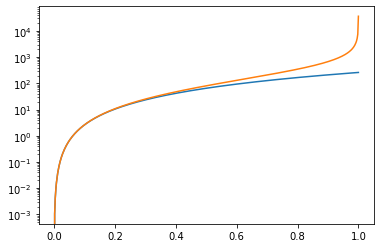

In [5]:
plt.plot(vsp,ec)
plt.plot(vsp,er)
plt.yscale('log')

In [6]:
k_from_v(0.26)

Vel 0.26 c
  Gamma = 1.0356162766686667
  Classic 17.672316480000003 keV
  Relativ 18.621956009701737 keV


(17.672316480000003, 18.621956009701737)

In [7]:
X1=10
Y1=0.05
X2=20.6
Y2=0.02
Xint=20
m = (Y2-Y1)/(X2-X1)
d= 1.26
m2 = -d*0.00224618
b = Y1-m*X1
print(m,b)



print(integ)

-0.002830188679245283 0.07830188679245283


NameError: name 'integ' is not defined

In [8]:
def integrate(X1,Y1,X2,d1,d2,bkE):
    m1 = -d1*0.00224618
    m2 = -d2*0.00224618
    b1 = Y1-m1*X1
    #print(m1,b1)
    if(X2<=bkE):
        return  max(0,m1*(((X2**2)/2.)-((X1**2)/2.)) + b1*(X2-X1))
    else:
        int_low = integrate(X1,Y1,bkE,d1,d2,bkE)
        ybke = m1*bkE+b1
        b2 = ybke-m2*bkE
        
        x2_stop = -b2/m2
        print(x2_stop)
        
        
        int_high = m2*(((x2_stop**2)/2.)-((bkE**2)/2.)) + b2*(x2_stop-bkE)
        print(X2,int_low, int_high)
        return max(0,int_low) + max(0,int_high)




In [9]:
xx = [integrate(10,9.94,ene,5.52,3.46,40.8)for ene in range(10,60)]

1270.6482480905154
41 300.27094730124793 5877.514547604402
1270.6482480905154
42 300.27094730124793 5877.514547604402
1270.6482480905154
43 300.27094730124793 5877.514547604402
1270.6482480905154
44 300.27094730124793 5877.514547604402
1270.6482480905154
45 300.27094730124793 5877.514547604402
1270.6482480905154
46 300.27094730124793 5877.514547604402
1270.6482480905154
47 300.27094730124793 5877.514547604402
1270.6482480905154
48 300.27094730124793 5877.514547604402
1270.6482480905154
49 300.27094730124793 5877.514547604402
1270.6482480905154
50 300.27094730124793 5877.514547604402
1270.6482480905154
51 300.27094730124793 5877.514547604402
1270.6482480905154
52 300.27094730124793 5877.514547604402
1270.6482480905154
53 300.27094730124793 5877.514547604402
1270.6482480905154
54 300.27094730124793 5877.514547604402
1270.6482480905154
55 300.27094730124793 5877.514547604402
1270.6482480905154
56 300.27094730124793 5877.514547604402
1270.6482480905154
57 300.27094730124793 5877.5145476044

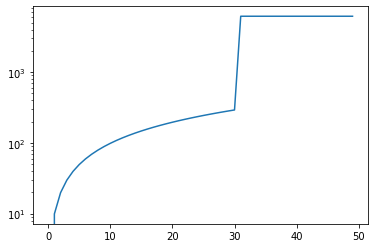

In [47]:
import matplotlib.pyplot as plt
plt.plot(xx)
plt.yscale('log')

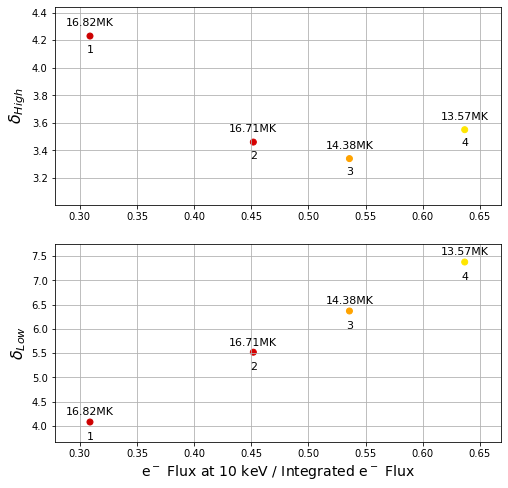

In [99]:
import pandas as pd
import seaborn as sns
#Tr = [12.06,16.82,16.71,14.38,13.57]
#T = np.log10(1e6*np.array(Tr))
#d = [1.26,4.08,5.52,6.37,7.38]
#dh = [12.6,4.23,3.46,3.34,3.55]
#eb = np.log10(np.array([20.6,3000,40.8,47.1,41.1]))
#g = [4.87,3.19,2.37,2.86,3.35]
#IEF = [0.389,4.5,22,20.9,25.6]
#F10 = [0.05,1.39,9.94,11.2,16.3]
#frac10 = np.array(F10)/np.array(IEF)
#fr = [0,1,2,3,4]


Tr = [16.82,16.71,14.38,13.57]
T = np.log10(1e6*np.array(Tr))
d = [4.08,5.52,6.37,7.38]
dh = [4.23,3.46,3.34,3.55]
eb = np.log10(np.array([3000,40.8,47.1,41.1]))
g = [3.19,2.37,2.86,3.35]
IEF = [4.5,22,20.9,25.6]
F10 = [1.39,9.94,11.2,16.3]
frac10 = np.array(F10)/np.array(IEF)
fr = [1,2,3,4]



t3 = ["No IPT3","No IPT3","IPT3","IPT3"]

cols = ["Log T","d_low","d_high","gamma","Log_Ebreak","F_10","IEF"]
data = [T,d,dh,g,eb,F10,IEF]
df = pd.DataFrame(np.array(data).T,columns=cols)
df["with_IPT3"] = t3

ar = [(d[i]/2.)*(eb[i]-10)**2 for i in range(len(d))]


plt.figure(figsize=(8,8))
x=frac10
y=dh
col=T
plt.subplot(2,1,1)
plt.scatter(x,y,c=col,cmap="jet",vmin=6.9,vmax=7.25)
for i in range(len(T)):
    txt = str(Tr[i])+"MK"
    cc = "k"
    if(t3[i]=="No IPT3"):
        cc="k"
    plt.text(x[i],y[i]+0.06,txt,ha="center",va="bottom",fontsize=11,c=cc)
    plt.text(x[i],y[i]-0.06,fr[i],ha="center",va="top",fontsize=11,c="k")
plt.xlim(0.9*(np.min(x)),1.05*(np.max(x)))
plt.ylim(0.9*(np.min(y)),1.05*(np.max(y)))
#plt.xlabel("e$^-$ Flux at 10 keV / Integrated e$^-$ Flux",fontsize=14)
plt.ylabel("$\delta_{High}$",fontsize=16)
plt.grid()
plt.subplot(2,1,2)
x=frac10
y=d
col=T
plt.scatter(x,y,c=col,cmap="jet",vmin=6.9,vmax=7.25)
for i in range(len(T)):
    txt = str(Tr[i])+"MK"
    cc = "k"
    if(t3[i]=="No IPT3"):
        cc="k"
    plt.text(x[i],y[i]+0.1,txt,ha="center",va="bottom",fontsize=11,c=cc)
    plt.text(x[i],y[i]-0.2,fr[i],ha="center",va="top",fontsize=11,c="k")
plt.xlim(0.9*(np.min(x)),1.05*(np.max(x)))
plt.ylim(0.9*(np.min(y)),1.05*(np.max(y)))
plt.ylabel("$\delta_{Low}$",fontsize=16)
plt.xlabel("e$^-$ Flux at 10 keV / Integrated e$^-$ Flux",fontsize=14)
plt.grid()
#plt.yscale("log")
#plt.xscale("log")


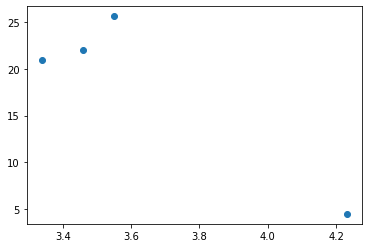

In [104]:
plt.scatter(dh,IEF)

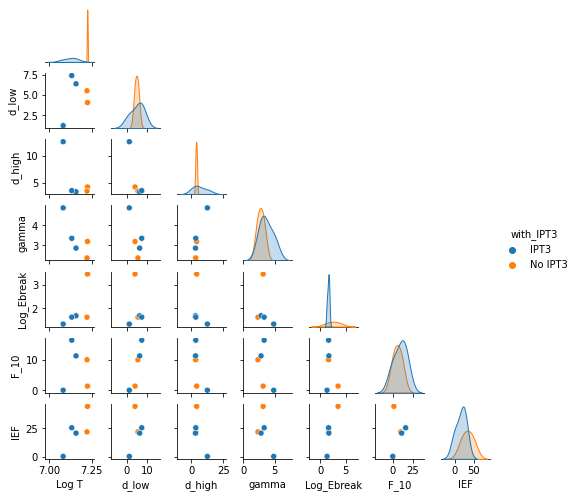

In [108]:
pl=sns.pairplot(df,diag_kind="kde",hue="with_IPT3",corner=True,height=1)
#pl.map_lower(sns.kdeplot, levels=3, color="#AAAAAA")

In [91]:
df

,frame,T,d_low,d_high,gamma,E_break,F_10,IEF,with_IPT3
0,0,7.0813473078041325,1.26,12.6,4.87,20.6,0.05,0.389,IPT3
1,1,7.225825991461893,4.08,4.23,3.19,3000,1.39,44.5,No IPT3
2,2,7.222976449893391,5.52,3.46,2.37,40.8,9.94,22,No IPT3
3,3,7.157758886046864,6.37,3.34,2.86,47.1,11.2,20.9,IPT3
4,4,7.132579847659737,7.38,3.55,3.35,41.1,16.3,25.6,IPT3


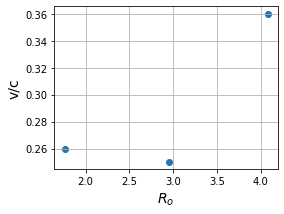

In [117]:
v = [0.25,0.36,0.26]
r = [2.95,4.08,1.76]
f=[4125,2075,5825]
labs = ["A","B","C"]
plt.figure(figsize=(4,3))
plt.scatter(r,v)
plt.ylabel("v/c",fontsize=14)
plt.xlabel("$R_o$",fontsize=14)
plt.grid()